In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import sklearn.preprocessing as sk
from scipy.sparse import csc_matrix


In [3]:
df = (pd.read_csv("../input/h_2_courses.csv")
        .rename(columns={"наименование": "course_name", "max-score, максим который набрать": "max_possible_score", 
                         "проходной ли балл?": "is_passed", "сам ли назначил?": "does_he_appointed",
                         "когда активирован курс": "course_activated_at", "когда завершен": "course_finished_at",
                         "в срок ли завершен": "completed_in_period"
                        })
        .drop(['Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 
               'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20'], 1)
        .assign(course_activated_at = lambda x: pd.to_datetime(x["course_activated_at"], dayfirst=True))
        .assign(course_finished_at = lambda x: pd.to_datetime(x["course_finished_at"], dayfirst=True))
     )

In [4]:
anketa = (pd.read_csv("../input/h_1_anketa.csv")
            .rename(columns={"Пол": "sex", "ДатаРождения": "birthdate", "ДатаПриема": "date_p",
                             "УИН Подразделения": "unit_id", "ЭтоРуководитель": "is_top_manager",
                             "Место рождения": "birth_place", "Должность": "position"
                            })
            .assign(birthdate = lambda x: pd.to_datetime(x["birthdate"], dayfirst=True, errors="coerce"))
            .assign(priem = lambda x: pd.to_datetime(x["date_p"], dayfirst=True))
         )

In [5]:
df = df.merge(anketa, how="left", on="uid")

In [6]:
course_encoder = sk.LabelEncoder()
user_encoder = sk.LabelEncoder()

prepeared = (df.drop(["max_possible_score", "score", "%", "completed_in_period"], 1)
           .assign(duration = lambda x: x["course_finished_at"] - x["course_activated_at"])
           .assign(age = lambda x: x["course_activated_at"] - x["birthdate"])
           .assign(priem = lambda x: x["course_activated_at"] - x["priem"])
           .drop(["course_finished_at", "course_activated_at"], 1)
           .assign(is_passed = lambda x: x.is_passed.apply(lambda el: 2 * el - 1))
           .assign(cid = lambda x: course_encoder.fit_transform(x.course_name))
           .assign(uid = lambda x: user_encoder.fit_transform(x.uid))
           .drop(["course_name"], 1)
           
        )

train = prepeared.groupby(["uid", "cid"])["is_passed"].max().reset_index()

In [7]:
from scipy.sparse import coo_matrix, csr_matrix

def convert_to_sparse(src):
    data = []
    row = []
    col = []
    
    for k in src:
        data.append(k[2])
        row.append(k[0])
        col.append(k[1])
    return coo_matrix((data, (row, col)))

In [8]:
from lightfm import LightFM

/Users/dpetrov/.anaconda/lib/python3.5/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [9]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

        
def training(X, *args, **kwargs):
    _cf_model = LightFM()
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    res = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        _cf_model.fit(convert_to_sparse(X_train))
        
        res.append(mean_squared_error(_cf_model.predict(X_test[:,0], X_test[:,1]), X_test[:,2]))
    return np.array(res).mean()
                              


In [43]:
# logistic’, ‘bpr’, ‘warp’, ‘warp-kos
cf_model = LightFM(no_components=30, loss="warp-kos")
cf_model.fit(convert_to_sparse(train.as_matrix()))

In [38]:
course_classes_df = (pd.read_csv("../input/course_classes.csv")
                       .rename(columns={"название": "course_name", "категория 1": "cat1", "категория 2": "cat2"})
                       .assign(cid = lambda x: course_encoder.transform(x.course_name.as_matrix()))
                       .assign(cat2 = lambda x: x.cat2.fillna(""))
                       .assign(ucat = lambda x: x.cat1 + ":" + x.cat2)
                    )

In [33]:
course_classes_df

,course_name,cat1,cat2,cid,ucat
0,CRM - Управление взаимоотношениями с клиентами,софт и по,клиентский сервис,0,софт и по:клиентский сервис
1,WebTutor,софт и по,webtutor,1,софт и по:webtutor
2,Английский_ публикация урока 16.02,английский,,2,английский:
3,Ассортимент Dell,продукция,,3,продукция:
4,Возможности программы Microsoft PowerPoint,софт и по,,4,софт и по:
5,Диалоги 1 и 2_webtutor,софт и по,webtutor,5,софт и по:webtutor
6,Диалоги 5 и 6_webtutor,софт и по,webtutor,6,софт и по:webtutor
7,"Дистанционный курс: ""Охрана труда"" Блок 2",охрана труда,,7,охрана труда:
8,Дистанционный курс_Охрана труда Блок 2,охрана труда,,8,охрана труда:
9,ИЗМЕНЕНИЯ В АКЦИИ_ИЮЛЬ,акции и спецпредложения,,9,акции и спецпредложения:


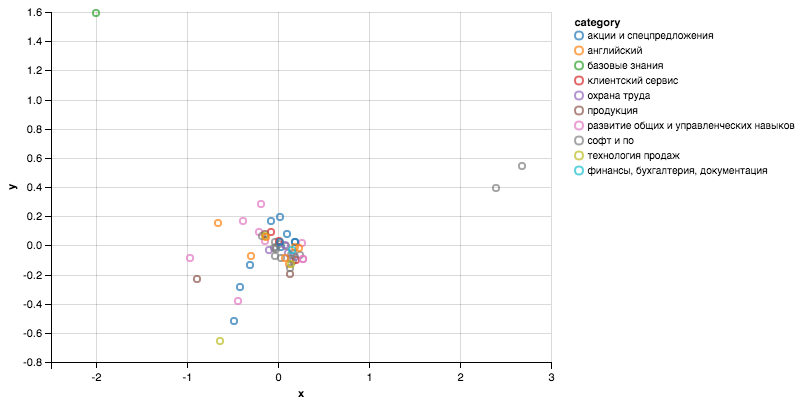

In [44]:
from altair import Chart
from sklearn.decomposition import PCA

courses_2d_presentation = PCA(n_components=2).fit_transform(cf_model.item_embeddings)
courses_2d_presentation_df = pd.DataFrame({'x': courses_2d_presentation[:,0], 'y': courses_2d_presentation[:,1],
                                           'category': course_classes_df.cat1.as_matrix(),
                                           'ucategory': course_classes_df.ucat.as_matrix()
                                          })

Chart(courses_2d_presentation_df).mark_point().encode(x = 'x', y = 'y', color='category')

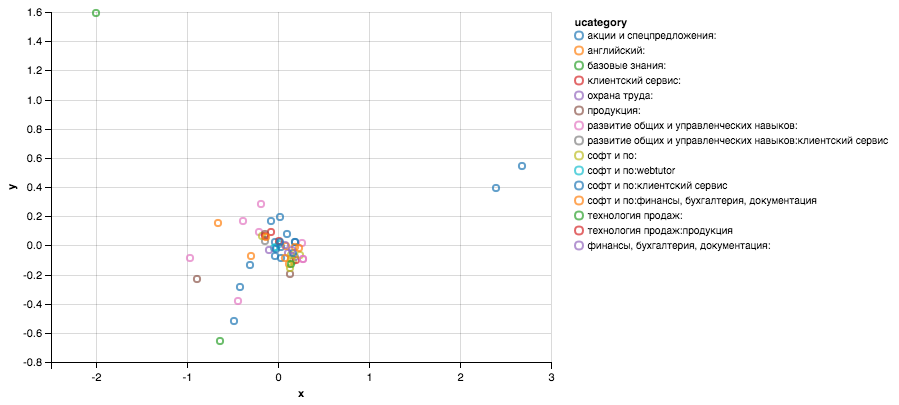

In [45]:
Chart(courses_2d_presentation_df).mark_point().encode(x = 'x', y = 'y', color='ucategory')

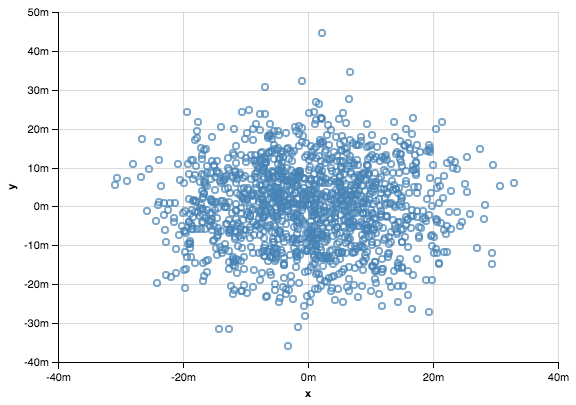

In [157]:

users_2d_presentation = PCA(n_components=2).fit_transform(cf_model.user_embeddings)
users_2d_presentation_df = pd.DataFrame({'x': users_2d_presentation[:,0], 'y': users_2d_presentation[:,1]})

Chart(users_2d_presentation_df).mark_point().encode(x = 'x', y = 'y')

In [231]:
prepeared.head()

,uid,is_passed,does_he_appointed,sex,birthdate,date_p,unit_id,is_top_manager,birth_place,position,priem,duration,age,cid
0,1401,1,0,ж,1989-12-08,23.06.2014,2872f097-722e-11e0-a872-001b789beaf2,0,Москва,Продавец,120 days,3 days,9083 days,44
1,1401,1,0,ж,1989-12-08,23.06.2014,2872f097-722e-11e0-a872-001b789beaf2,0,Москва,Продавец,107 days,5 days,9070 days,21
2,1401,1,1,ж,1989-12-08,23.06.2014,2872f097-722e-11e0-a872-001b789beaf2,0,Москва,Продавец,100 days,0 days,9063 days,50
3,1401,1,1,ж,1989-12-08,23.06.2014,2872f097-722e-11e0-a872-001b789beaf2,0,Москва,Продавец,96 days,0 days,9059 days,50
4,1401,1,0,ж,1989-12-08,23.06.2014,2872f097-722e-11e0-a872-001b789beaf2,0,Москва,Продавец,91 days,4 days,9054 days,16


In [235]:
def position_feature_matrix():
    _temp = pd.get_dummies(prepeared.position)
    return ["position_{}".format(x) for x in _temp.columns], _temp.as_matrix()

In [234]:
def birth_place_feature_matrix():
    _temp = pd.get_dummies(prepeared.birth_place)
    return ["birth_place_{}".format(x) for x in _temp.columns], _temp.as_matrix()

In [233]:
def is_top_manager_feature_matrix():
    _temp = pd.get_dummies(prepeared.is_top_manager)
    return ["is_top_manager_{}".format(x) for x in _temp.columns], _temp.as_matrix()

In [244]:
def date_p_feature_matrix():
    def chunk(dys):
        dys = dys / np.timedelta64(1, 'D')
        if dys < 3 * 30:
            return "less_3m"
        elif dys < 6 * 30:
            return "3_6m"
        elif dys < 12 * 30:
            return "6_12m"
        elif dys < 24 * 30:
            return "12_24m"
        elif dys < 48 * 30:
            return "24_48m"
        else:
            return "greater_48m"
    
    _temp = pd.get_dummies(prepeared.priem.apply(chunk))
    return ["priem_{}".format(x) for x in _temp.columns], _temp.as_matrix()

In [246]:
def age_feature_matrix():
    def chank(fys):
        fys = fys / np.timedelta64(1, 'D')
        if fys < 18 * 365:
            return "less_18y"
        elif fys < 22 * 365:
            return "18_22y"
        elif fys < 28 * 365:
            return "23_28y"
        elif fys < 35 * 365:
            return "29_35y"
        elif fys < 45 * 365:
            return "36_45y"
        elif fys < 60 * 365:
            return "46_60y"
        else:
            return "greater_60y"
    _temp = pd.get_dummies(prepeared.age.apply(chank))
    return ["age_{}".format(x) for x in _temp.columns], _temp.as_matrix()

In [188]:
def unit_id_feature_matrix():
    _temp = pd.get_dummies(prepeared.unit_id)
    return ["unit_id_{}".format(x) for x in _temp.columns], _temp.as_matrix()

In [182]:
def sex_feature_matrix():
    _temp = pd.get_dummies(prepeared.sex)
    return ["sex_{}".format(x) for x in _temp.columns], _temp.as_matrix()

In [161]:
def uid_feature_matrix():
    res = []
    for uid in prepeared.uid.as_matrix():
        res.append(cf_model.user_embeddings[uid])
    return np.array(["user_embed_{}".format(i) for i, _ in enumerate(cf_model.user_embeddings[uid])]), np.array(res)

uid_feature_matrix()[1].shape

(16229, 30)

In [162]:
def cid_feature_matrix():
    res = []
    for cid in prepeared.cid.as_matrix():
        res.append(cf_model.item_embeddings[cid])
    return np.array(["item_embed_{}".format(i) for i, _ in enumerate(cf_model.item_embeddings[cid])]), np.array(res)

cid_feature_matrix()[1].shape

(16229, 30)

In [183]:
def does_he_appointed_feature_matrix():

    _temp = pd.get_dummies(prepeared.does_he_appointed)
    return ["appointed_{}".format(x) for x in _temp.columns], _temp.as_matrix()

In [249]:
def duration_feature_matrix():
    def chunk(dys):
        dys = dys / np.timedelta64(1, 'D')
        if dys == 0:
            return "0d"
        elif dys < 2:
            return "1_2d"
        elif dys < 5:
            return "3_5d"
        elif dys < 14:
            return "6_14d"
        else:
            return "greater_15d"
        
    _temp = pd.get_dummies(prepeared.duration.apply(chunk))
    return ["duration_{}".format(x) for x in _temp.columns], _temp.as_matrix()

In [267]:
position_feature_clmns, position_feature_mtrx = position_feature_matrix()
birth_place_clmns, birth_place_mtrx = birth_place_feature_matrix()
is_top_manager_clmns, is_top_manager_mtrx = is_top_manager_feature_matrix()
date_p_clmns, date_p_mtrx = date_p_feature_matrix()
age_clmns, age_mtrx = age_feature_matrix()
unit_id_clmns, unit_id_mtrx = unit_id_feature_matrix()
sex_feature_clmns, sex_feature_mtrx = sex_feature_matrix()
uid_feature_clmns, uid_feature_mtrx = uid_feature_matrix()
cid_feature_clmns, cid_feature_mtrx = cid_feature_matrix()
appointed_feature_clmns, appointed_feature_mtrx = does_he_appointed_feature_matrix()
duration_feature_clmns, duration_feature_mtrx = duration_feature_matrix()

clmn_names = []
for lst in (#position_feature_clmns,
            #birth_place_clmns,
            is_top_manager_clmns,
            date_p_clmns,
            age_clmns,
            unit_id_clmns,
            sex_feature_clmns, 
            cid_feature_clmns, 
            appointed_feature_clmns, 
            duration_feature_clmns):
    clmn_names.extend(list(lst))

X = np.hstack((#position_feature_mtrx,
               #birth_place_mtrx,
               is_top_manager_mtrx,
               date_p_mtrx,
               age_mtrx,unit_id_mtrx,
               sex_feature_mtrx, 
               cid_feature_mtrx, 
               appointed_feature_mtrx, 
               duration_feature_mtrx))
y = prepeared.is_passed.apply(lambda x: (x + 1) / 2).as_matrix()

In [169]:
X.shape

(16229, 228)

In [ ]:

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = LogisticRegressionCV(penalty="l1", solver="liblinear", n_jobs=16)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv.split(X, y), colors):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [258]:
for t in zip(clmn_names, classifier.coef_[0]):
    print("{}: {}".format(t[0], t[1]))

position_Ассистент руководителя программ и проектов: 0.0
position_Бизнес-аналитик: -0.0006961427241122086
position_Бренд-менеджер: -0.010102839561784979
position_Бухгалтер-кассир: -0.011792737990275973
position_Ведущий бизнес-тренер: -0.014052304401208039
position_Ведущий менеджер по развитию: -0.0009391400871739759
position_Ведущий программист: 0.0
position_Ведущий тренинг-менеджер: -0.043242055663337345
position_Ведущий экономист: -0.004415988295181727
position_Делопроизводитель: 0.004349089800983605
position_Дизайнер по оформлению фасадов: -0.0009604563902612217
position_Директор департамента: 0.0
position_Директор по информационным технологиям: 0.0016633351921051765
position_Диспетчер службы заказов: 0.0012138471319758765
position_Заместитель директора по развитию: -0.000897009695428311
position_Заместитель управляющего: 0.12142517377268826
position_Заместитель финансового директора по финансовому учету и отчетности: -0.0042288870134294205
position_И.о. директора: -0.00803189634259